# Introduction to Synthetic Population Generation

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from caveat.data.synth import ActivityGen
from caveat.data.utils import generate_population, trace_to_pam

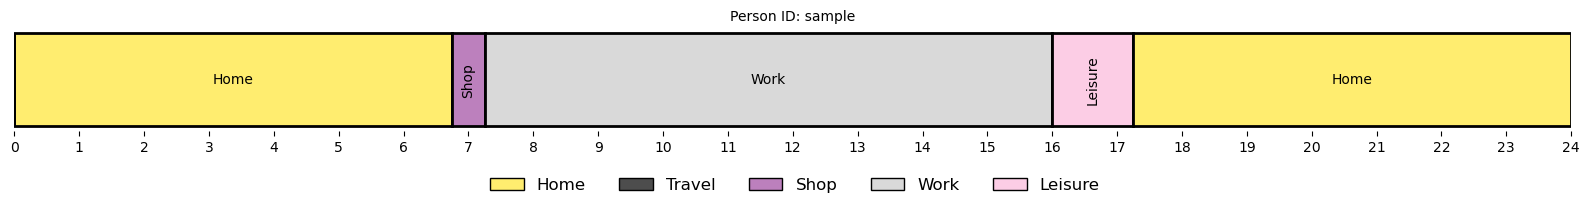

In [2]:
# Example
generator = ActivityGen()
generator.build()

trace = generator.run()
plan = trace_to_pam(trace, generator.map)
plan.plot()

In [3]:
population = generate_population(gen=generator, size=1000)
population.act = population.act.map(generator.map)
population = population[["pid", "act", "start", "end", "duration"]]
population

,pid,act,start,end,duration
0,0,home,0,405,405
1,0,work,405,915,510
2,0,shop,915,960,45
3,0,home,960,1440,480
4,1,home,0,420,420
...,...,...,...,...,...
5032,999,home,0,390,390
5033,999,shop,390,435,45
5034,999,work,435,975,540
5035,999,education,975,1080,105


In [4]:
write_path = Path("tmp/example_population.csv")
write_path.parent.mkdir(exist_ok=True)
population.to_csv(write_path, index=False)

In [5]:
def describe_col(population, col: str) -> pd.DataFrame:
    description = population.groupby("act")[col].describe()[
        ["count", "mean", "std", "min", "max"]
    ]
    description["attribute"] = col
    return description


def describe_cols(population, cols: list[str]) -> pd.DataFrame:
    description = pd.concat(
        [describe_col(population, c) for c in cols], ignore_index=False
    )
    description = description.reset_index().set_index(["attribute", "act"])
    return description


describe_cols(population, ["start", "end", "duration"]).round()

count   mean    std    min     max
attribute act                                           
start     education   459.0  863.0  175.0  390.0  1170.0
          home       2156.0  556.0  521.0    0.0  1365.0
          leisure     606.0  834.0  291.0  375.0  1305.0
          shop        808.0  632.0  288.0  375.0  1200.0
          work       1008.0  420.0   66.0  375.0  1230.0
end       education   459.0  981.0  164.0  435.0  1185.0
          home       2156.0  930.0  511.0  375.0  1440.0
          leisure     606.0  893.0  304.0  390.0  1365.0
          shop        808.0  668.0  285.0  390.0  1215.0
          work       1008.0  929.0   77.0  750.0  1245.0
duration  education   459.0  118.0   48.0   15.0   270.0
          home       2156.0  375.0   78.0   15.0   570.0
          leisure     606.0   60.0   25.0   15.0   150.0
          shop        808.0   36.0   26.0   15.0   165.0
          work       1008.0  509.0   70.0   15.0   675.0

In [6]:
def time_distributions(population: pd.DataFrame, mapping: dict):
    starts = {k: [] for k in mapping.values()}
    ends = {k: [] for k in mapping.values()}
    durations = {k: [] for k in mapping.values()}
    for act, acts in population.groupby("act"):
        starts[act] = list(acts.start)
        ends[act] = list(acts.end)
        durations[act] = list(acts.duration)
    return starts, ends, durations

In [7]:
starts, ends, durations = time_distributions(population, generator.map)

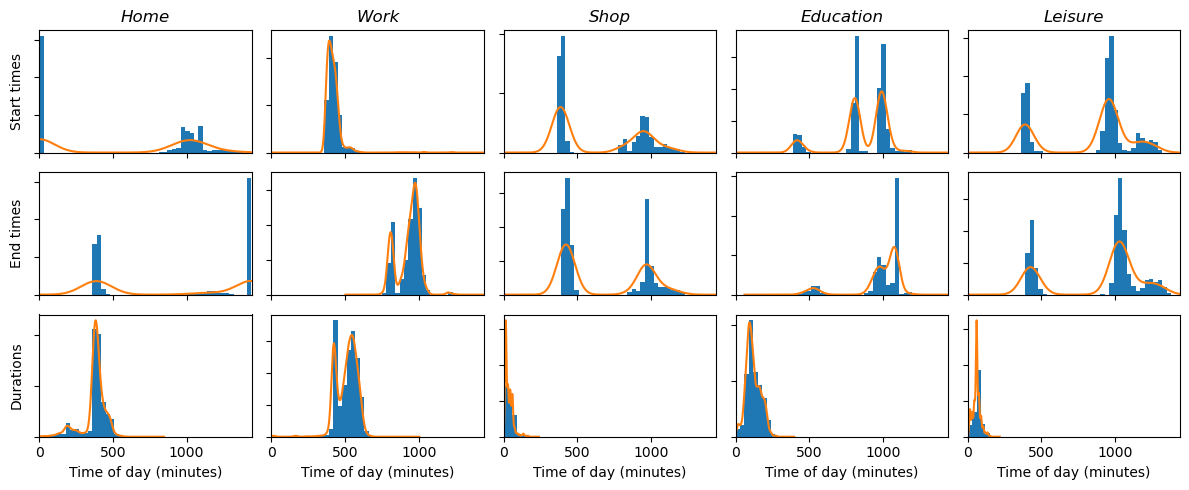

In [8]:
step = 30
mini = 0
maxi = 1441
ind = 1000
bw_method = 0.2

bins = list(range(mini, maxi, step))
fig, axs = plt.subplots(
    3,
    len(starts),
    figsize=(12, 5),
    sharex=True,
    sharey=False,
    tight_layout=True,
)
for i, act in enumerate(starts.keys()):
    axs[0][i].set_title(act.title(), fontstyle="italic")
    axs[0][i].hist(starts[act], bins=bins, density=True)
    pd.Series(starts[act]).plot.kde(ind=ind, bw_method=bw_method, ax=axs[0][i])
    axs[0][i].set_xlim(mini, maxi)
    axs[0][i].set_yticklabels([])
    axs[0][i].set(ylabel=None)
    axs[0][0].set(ylabel="Start times")

    axs[1][i].hist(ends[act], bins=bins, density=True)
    pd.Series(ends[act]).plot.kde(ind=ind, bw_method=bw_method, ax=axs[1][i])
    axs[1][i].set_xlim(mini, maxi)
    axs[1][i].set_yticklabels([])
    axs[1][i].set(ylabel=None)
    axs[1][0].set(ylabel="End times")

    axs[2][i].hist(durations[act], bins=bins, density=True)
    pd.Series(durations[act]).plot.kde(
        ind=ind, bw_method=bw_method, ax=axs[2][i]
    )
    axs[2][i].set_xlim(mini, maxi)
    axs[2][i].set_yticklabels([])
    axs[2][i].set(ylabel=None)
    axs[2][0].set(ylabel="Durations")
    axs[2][i].set(xlabel="Time of day (minutes)")

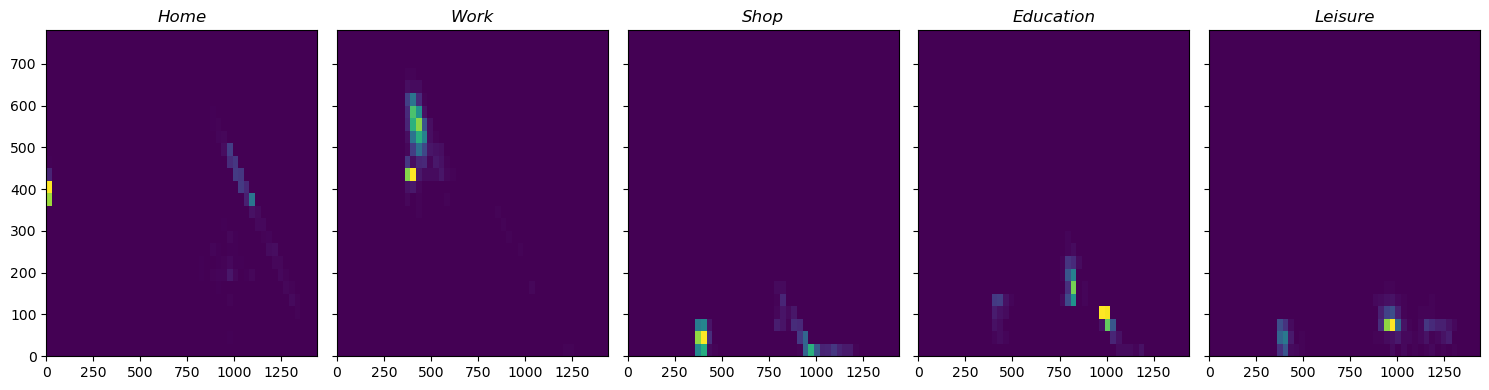

In [9]:
step = 30
mini = 0
maxi = 1441

bins = list(range(mini, maxi, step))
duration_bins = list(range(mini, 800, step))

fig, axs = plt.subplots(
    1, len(starts), figsize=(15, 4), sharex=True, sharey=True, tight_layout=True
)
for i, (act, act_starts) in enumerate(starts.items()):
    act_durations = durations[act]

    axs[i].set_title(act.title(), fontstyle="italic")
    axs[i].hist2d(act_starts, act_durations, bins=(bins, duration_bins))